In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, datediff, to_date, avg, count
import json
import matplotlib.pyplot as plt
import numpy as np


spark = SparkSession.builder \
    .master("local[*]") \
    .appName("MySparkApp") \
    .getOrCreate()


25/03/29 13:34:29 WARN Utils: Your hostname, ana resolves to a loopback address: 127.0.1.1; using 192.168.110.240 instead (on interface wlo1)
25/03/29 13:34:29 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/29 13:34:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/03/29 13:34:30 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
# Cargamos los datasets modificados de XM, BR y US
data_set_MX = spark.read.option("inferSchema", "true").option("header", "true").csv("/home/shinening96/proyectoSpark/datasets/MX.csv")
data_set_BR = spark.read.option("inferSchema", "true").option("header", "true").csv("/home/shinening96/proyectoSpark/datasets/BR.csv")
data_set_US = spark.read.option("inferSchema", "true").option("header", "true").csv("/home/shinening96/proyectoSpark/datasets/US.csv")

# contar cuantos videos tiene en cada daataset
print("Cantidad de videos en MX: ", data_set_MX.count())
print("Cantidad de videos en BR: ", data_set_BR.count())
print("Cantidad de videos en US: ", data_set_US.count())

Cantidad de videos en MX:  268598
Cantidad de videos en BR:  268790
Cantidad de videos en US:  268787


In [4]:
# Cargar el json de las categorias para MX
with open("/home/shinening96/proyectoSpark/datasets/MX_category_id.json", "r") as file:
    data_set_categories_MX = json.load(file)

# Crear un diccionario con las categorias
categoriesMX = {}
for category in data_set_categories_MX["items"]:
    categoriesMX[category["id"]] = category["snippet"]["title"]

# Crear un dataframe con las categorias
data_set_categories_MX = spark.createDataFrame(categoriesMX.items(), ["category_id", "category_name"])

data_set_categories_MX.show(truncate=False, n=100)


+-----------+--------------------+
|category_id|category_name       |
+-----------+--------------------+
|1          |Film & Animation    |
|2          |Autos & Vehicles    |
|10         |Music               |
|15         |Pets & Animals      |
|17         |Sports              |
|18         |Short Movies        |
|19         |Travel & Events     |
|20         |Gaming              |
|21         |Videoblogging       |
|22         |People & Blogs      |
|23         |Comedy              |
|24         |Entertainment       |
|25         |News & Politics     |
|26         |Howto & Style       |
|27         |Education           |
|28         |Science & Technology|
|30         |Movies              |
|31         |Anime/Animation     |
|32         |Action/Adventure    |
|33         |Classics            |
|34         |Comedy              |
|35         |Documentary         |
|36         |Drama               |
|37         |Family              |
|38         |Foreign             |
|39         |Horror 

In [5]:
# Cargar el json de las categorias para BR
with open("/home/shinening96/proyectoSpark/datasets/BR_category_id.json", "r") as file:
    data_set_categories_BR = json.load(file)

# Crear un diccionario con las categorias
categoriesBR = {}
for category in data_set_categories_BR["items"]:
    categoriesBR[category["id"]] = category["snippet"]["title"]

# Crear un dataframe con las categorias
data_set_categories_BR = spark.createDataFrame(categoriesBR.items(), ["category_id", "category_name"])

data_set_categories_BR.show(truncate=False, n=100)


+-----------+--------------------+
|category_id|category_name       |
+-----------+--------------------+
|1          |Film & Animation    |
|2          |Autos & Vehicles    |
|10         |Music               |
|15         |Pets & Animals      |
|17         |Sports              |
|18         |Short Movies        |
|19         |Travel & Events     |
|20         |Gaming              |
|21         |Videoblogging       |
|22         |People & Blogs      |
|23         |Comedy              |
|24         |Entertainment       |
|25         |News & Politics     |
|26         |Howto & Style       |
|27         |Education           |
|28         |Science & Technology|
|30         |Movies              |
|31         |Anime/Animation     |
|32         |Action/Adventure    |
|33         |Classics            |
|34         |Comedy              |
|35         |Documentary         |
|36         |Drama               |
|37         |Family              |
|38         |Foreign             |
|39         |Horror 

In [6]:
# Cargar el json de las categorias para US
with open("/home/shinening96/proyectoSpark/datasets/US_category_id.json", "r") as file:
    data_set_categories_US = json.load(file)

# Crear un diccionario con las categorias
categoriesUS = {}
for category in data_set_categories_US["items"]:
    categoriesUS[category["id"]] = category["snippet"]["title"]

# Crear un dataframe con las categorias
data_set_categories_US = spark.createDataFrame(categoriesUS.items(), ["category_id", "category_name"])

data_set_categories_US.show(truncate=False, n=100)


+-----------+---------------------+
|category_id|category_name        |
+-----------+---------------------+
|1          |Film & Animation     |
|2          |Autos & Vehicles     |
|10         |Music                |
|15         |Pets & Animals       |
|17         |Sports               |
|18         |Short Movies         |
|19         |Travel & Events      |
|20         |Gaming               |
|21         |Videoblogging        |
|22         |People & Blogs       |
|23         |Comedy               |
|24         |Entertainment        |
|25         |News & Politics      |
|26         |Howto & Style        |
|27         |Education            |
|28         |Science & Technology |
|29         |Nonprofits & Activism|
|30         |Movies               |
|31         |Anime/Animation      |
|32         |Action/Adventure     |
|33         |Classics             |
|34         |Comedy               |
|35         |Documentary          |
|36         |Drama                |
|37         |Family         

In [47]:
# MEXICO
# Crear una nueva columna con la diferencia de días entre trending_date y publishedAt
data_set_with_diff_MX = data_set_MX.withColumn(
    "diff_days", datediff(to_date(col("trending_date")), to_date(col("publishedAt")))
)

# Calcular el número de videos y el promedio de días a tendencia por categoría
resultMX = data_set_with_diff_MX.groupBy("categoryId").agg(
    count("video_id").alias("number_videos"),
    avg("diff_days").alias("promedio_diff_dias_a_tendencia")
)


resultMX = resultMX.orderBy("categoryId")
resultMX.show(truncate=False, n=100)


# Unir el dataframe de categorías con el resultado
resultMX = resultMX.join(data_set_categories_MX, resultMX.categoryId == data_set_categories_MX.category_id).drop("category_id")
resultMX = resultMX.select("categoryId", "category_name", "number_videos", "promedio_diff_dias_a_tendencia")
resultMX = resultMX.orderBy(col("categoryId").cast("int"))

resultMX.show(truncate=False, n=100)


+----------+-------------+------------------------------+
|categoryId|number_videos|promedio_diff_dias_a_tendencia|
+----------+-------------+------------------------------+
|1         |7229         |5.193111080370729             |
|2         |2488         |4.768488745980707             |
|10        |61626        |5.263184370233343             |
|15        |156          |5.596153846153846             |
|17        |25385        |4.323655702186331             |
|19        |1640         |4.7213414634146345            |
|20        |42128        |5.00121059627801              |
|22        |33959        |5.1706764038988196            |
|23        |9665         |4.868494568028971             |
|24        |63158        |4.989502517495804             |
|25        |10307        |4.519258756185117             |
|26        |6642         |4.8983739837398375            |
|27        |1941         |5.150953116950026             |
|28        |2099         |4.935207241543592             |
|29        |17

+----------+--------------------+-------------+------------------------------+
|categoryId|category_name       |number_videos|promedio_diff_dias_a_tendencia|
+----------+--------------------+-------------+------------------------------+
|1         |Film & Animation    |7229         |5.193111080370729             |
|2         |Autos & Vehicles    |2488         |4.768488745980707             |
|10        |Music               |61626        |5.263184370233343             |
|15        |Pets & Animals      |156          |5.596153846153846             |
|17        |Sports              |25385        |4.323655702186331             |
|19        |Travel & Events     |1640         |4.7213414634146345            |
|20        |Gaming              |42128        |5.00121059627801              |
|22        |People & Blogs      |33959        |5.1706764038988196            |
|23        |Comedy              |9665         |4.868494568028971             |
|24        |Entertainment       |63158        |4.989

In [48]:
# BRASIL
# Crear una nueva columna con la diferencia de días entre trending_date y publishedAt
data_set_with_diff_BR = data_set_BR.withColumn(
    "diff_days", datediff(to_date(col("trending_date")), to_date(col("publishedAt")))
)

# Calcular el número de videos y el promedio de días a tendencia por categoría
resultBR = data_set_with_diff_BR.groupBy("categoryId").agg(
    count("video_id").alias("number_videos"),
    avg("diff_days").alias("promedio_diff_dias_a_tendencia")
)

resultBR = resultBR.orderBy("categoryId")
resultBR.show(truncate=False, n=100)

# Unir el dataframe de categorías con el resultado
resultBR = resultBR.join(data_set_categories_BR, resultBR.categoryId == data_set_categories_BR.category_id).drop("category_id")
resultBR = resultBR.select("categoryId", "category_name", "number_videos", "promedio_diff_dias_a_tendencia")
resultBR = resultBR.orderBy(col("categoryId").cast("int"))

resultBR.show(truncate=False, n=100)


+----------+-------------+------------------------------+
|categoryId|number_videos|promedio_diff_dias_a_tendencia|
+----------+-------------+------------------------------+
|1         |3329         |4.174226494442776             |
|2         |2603         |4.17402996542451              |
|10        |58413        |4.304401417492682             |
|15        |323          |3.5510835913312695            |
|17        |40716        |3.519451812555261             |
|19        |1403         |4.128296507483963             |
|20        |40437        |3.772460865049336             |
|22        |32594        |3.970608087378045             |
|23        |10380        |3.9103082851637767            |
|24        |64925        |3.789526376588371             |
|25        |4588         |4.048387096774194             |
|26        |2026         |4.204837117472853             |
|27        |3150         |3.8022222222222224            |
|28        |3835         |3.953846153846154             |
|29        |68

+----------+--------------------+-------------+------------------------------+
|categoryId|category_name       |number_videos|promedio_diff_dias_a_tendencia|
+----------+--------------------+-------------+------------------------------+
|1         |Film & Animation    |3329         |4.174226494442776             |
|2         |Autos & Vehicles    |2603         |4.17402996542451              |
|10        |Music               |58413        |4.304401417492682             |
|15        |Pets & Animals      |323          |3.5510835913312695            |
|17        |Sports              |40716        |3.519451812555261             |
|19        |Travel & Events     |1403         |4.128296507483963             |
|20        |Gaming              |40437        |3.772460865049336             |
|22        |People & Blogs      |32594        |3.970608087378045             |
|23        |Comedy              |10380        |3.9103082851637767            |
|24        |Entertainment       |64925        |3.789

In [49]:
# ESTADOS UNIDOS
# Crear una nueva columna con la diferencia de días entre trending_date y publishedAt
data_set_with_diff_US = data_set_US.withColumn(
    "diff_days", datediff(to_date(col("trending_date")), to_date(col("publishedAt")))
)

# Calcular el número de videos y el promedio de días a tendencia por categoría
resultUS = data_set_with_diff_US.groupBy("categoryId").agg(
    count("video_id").alias("number_videos"),
    avg("diff_days").alias("promedio_diff_dias_a_tendencia")
)

resultUS = resultUS.orderBy("categoryId")
resultUS.show(truncate=False, n=100)

# Unir el dataframe de categorías con el resultado
resultUS = resultUS.join(data_set_categories_US, resultUS.categoryId == data_set_categories_US.category_id).drop("category_id")
resultUS = resultUS.select("categoryId", "category_name", "number_videos", "promedio_diff_dias_a_tendencia")
resultUS = resultUS.orderBy(col("categoryId").cast("int"))

resultUS.show(truncate=False, n=100)


+----------+-------------+------------------------------+
|categoryId|number_videos|promedio_diff_dias_a_tendencia|
+----------+-------------+------------------------------+
|1         |10923        |3.2195367573011078            |
|2         |5492         |2.998179169701384             |
|10        |43398        |3.324600211991336             |
|15        |1222         |3.228314238952537             |
|17        |31327        |3.264596035368851             |
|19        |1713         |3.0297723292469354            |
|20        |53242        |3.0461289959054882            |
|22        |22653        |3.2702511808590473            |
|23        |13183        |3.2706515967533947            |
|24        |53934        |3.5383802425186337            |
|25        |9669         |3.8113558796152653            |
|26        |7100         |3.1766197183098592            |
|27        |6655         |3.1068369646882044            |
|28        |8156         |3.1120647376164787            |
|29        |12

+----------+---------------------+-------------+------------------------------+
|categoryId|category_name        |number_videos|promedio_diff_dias_a_tendencia|
+----------+---------------------+-------------+------------------------------+
|1         |Film & Animation     |10923        |3.2195367573011078            |
|2         |Autos & Vehicles     |5492         |2.998179169701384             |
|10        |Music                |43398        |3.324600211991336             |
|15        |Pets & Animals       |1222         |3.228314238952537             |
|17        |Sports               |31327        |3.264596035368851             |
|19        |Travel & Events      |1713         |3.0297723292469354            |
|20        |Gaming               |53242        |3.0461289959054882            |
|22        |People & Blogs       |22653        |3.2702511808590473            |
|23        |Comedy               |13183        |3.2706515967533947            |
|24        |Entertainment        |53934 

In [50]:
# Convertir los resultados a Pandas para poder graficar los resultados
resultMXPandas = resultMX.toPandas()
resultBRPandas = resultBR.toPandas()
resultUSPandas = resultUS.toPandas()

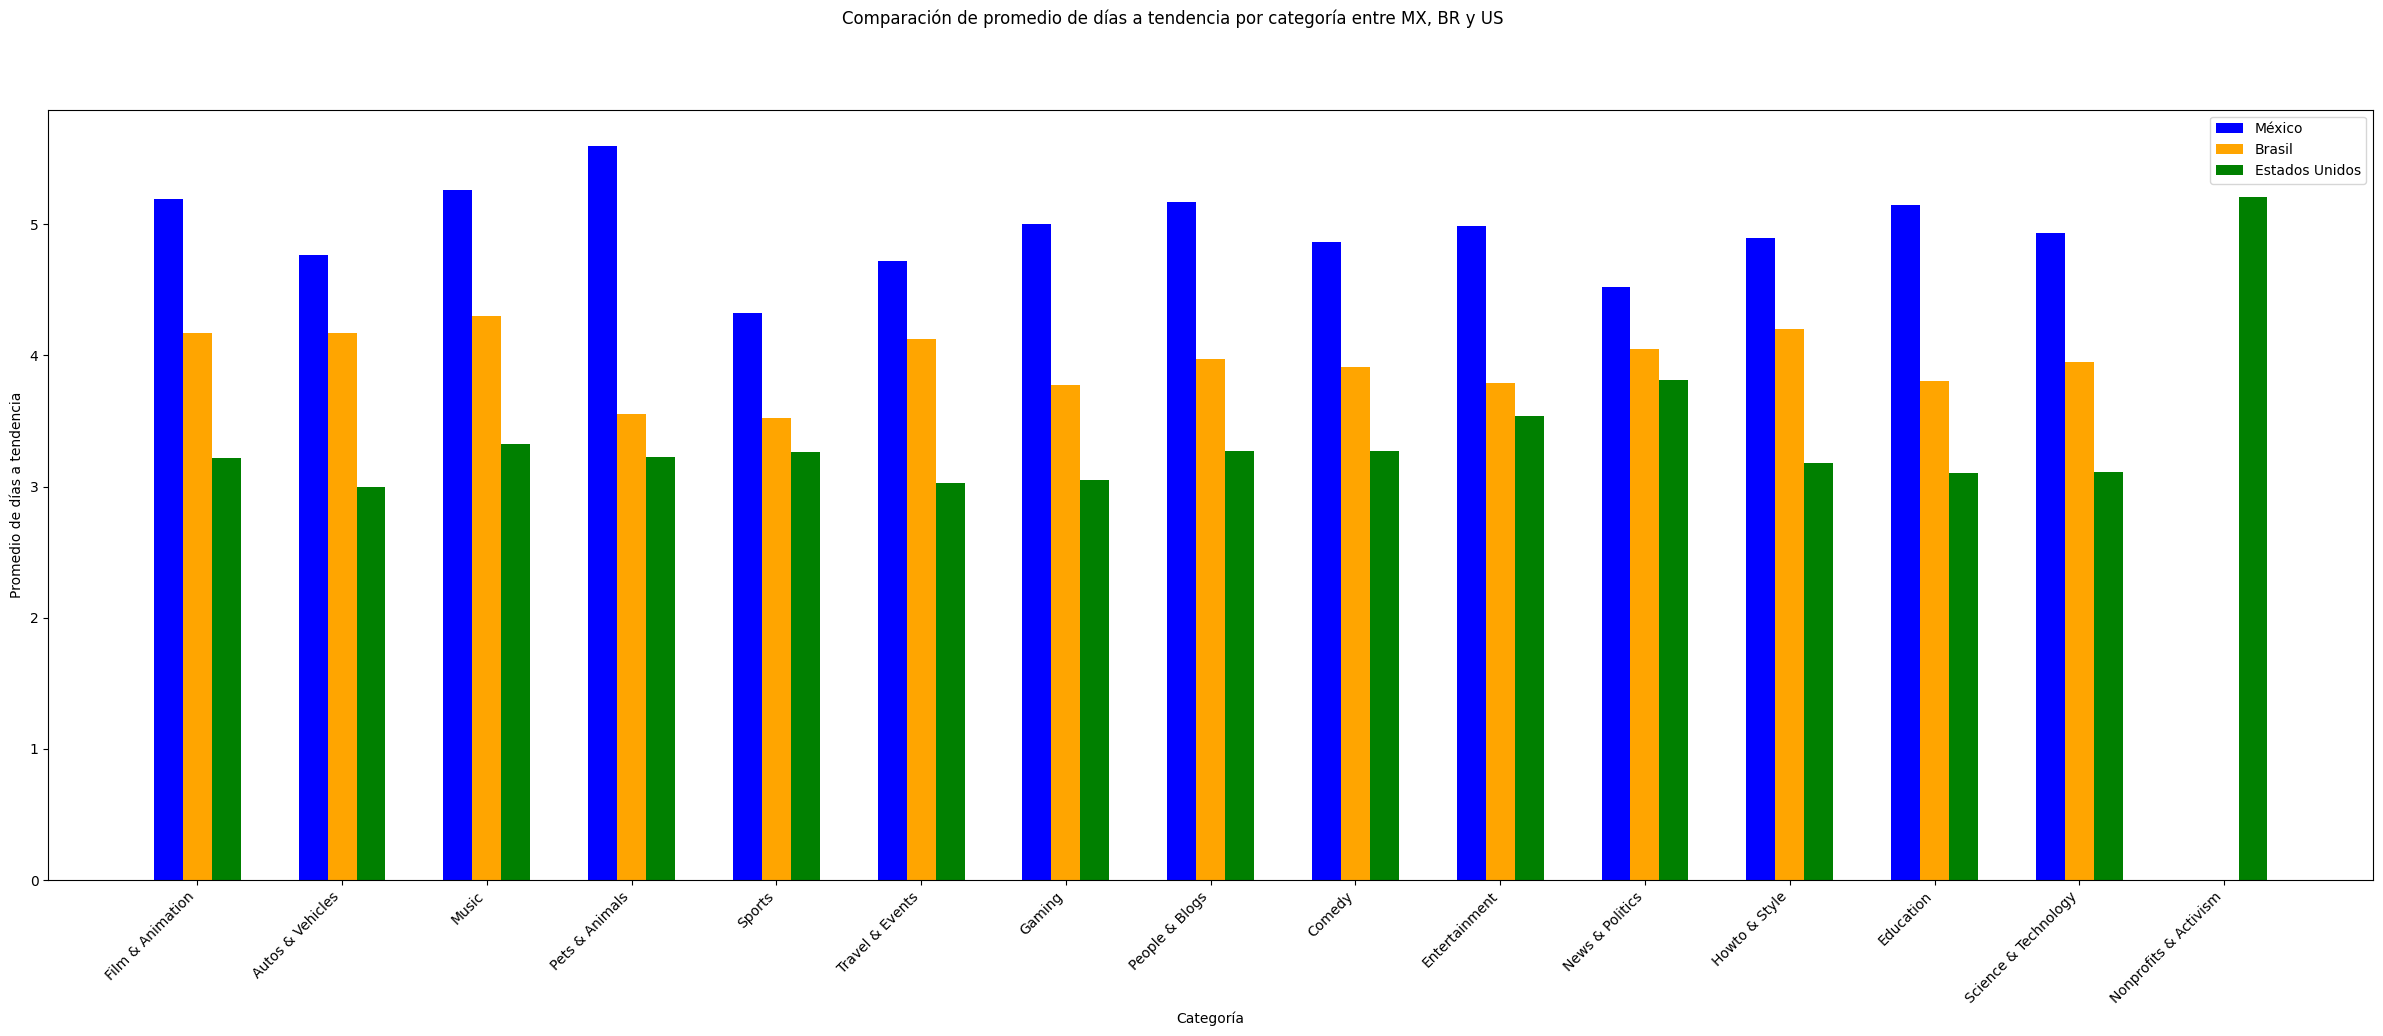

In [51]:
# Graficar el promedio de días a tendencia por categoría en MX, BR y US

# Ancho de las barras
width = 0.2

fig, axs = plt.subplots(1, 1, figsize=(30, 10))
fig.suptitle("Comparación de promedio de días a tendencia por categoría entre MX, BR y US")

categoriesMXAligned = resultMXPandas["category_name"].unique()
categoriesBRAligned = resultBRPandas["category_name"].unique()
categoriesUSAligned = resultUSPandas["category_name"].unique()

xMX = np.arange(len(categoriesMXAligned))
xBR = np.arange(len(categoriesBRAligned))
xUS = np.arange(len(categoriesUSAligned))

axs.bar(xMX - width, resultMXPandas["promedio_diff_dias_a_tendencia"], width, color="blue", label="México")
axs.bar(xBR, resultBRPandas["promedio_diff_dias_a_tendencia"], width, color="orange", label="Brasil")
axs.bar(xUS + width, resultUSPandas["promedio_diff_dias_a_tendencia"], width, color="green", label="Estados Unidos")
axs.set_xticks(np.arange(max(len(categoriesMXAligned), len(categoriesBRAligned), len(categoriesUSAligned))))
axs.set_xticklabels(categoriesUSAligned, rotation=45, ha="right")
axs.set_ylabel("Promedio de días a tendencia")
axs.set_xlabel("Categoría")
axs.legend()